### 代码实现

In [1]:
# 导入必要的库
import torch
import torch.nn as nn

In [2]:
# 导入 torchvision.models 中的 resnet18 和 ResNet18_Weights
from torchvision.models import resnet18, ResNet18_Weights

# 使用 resnet18 创建一个模型，并指定权重为默认权重
# 其中默认权重对应 ImageNet 数据集预训练模型的权重
model = resnet18(weights = ResNet18_Weights.DEFAULT)

In [3]:
# 遍历模型的所有参数，并将其 requires_grad 属性设置为 False
# 冻结模型参数，使它们在训练过程中不会被更新
for parameter in model.parameters():
    parameter.requires_grad = False

In [4]:
# 打印模型结构
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# 使用 nn.Linear 创建一个全连接层，输入特征维度为 512，输出特征维度为 102 进行替换
model.fc = nn.Linear(in_features=512, out_features=102, bias=True)

In [6]:
# 遍历模型的所有参数，并打印出它们的名称和 requires_grad 属性
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

### 模型训练

Epoch: 0 Loss: 2.5978439893210212 Acc: 0.15098039215686274
Epoch: 10 Loss: 2.0516573743560977 Acc: 0.7274509803921568
Epoch: 20 Loss: 1.8921139150187416 Acc: 0.8245098039215686
100%|██████████| 30/30 [09:39<00:00, 19.33s/it]


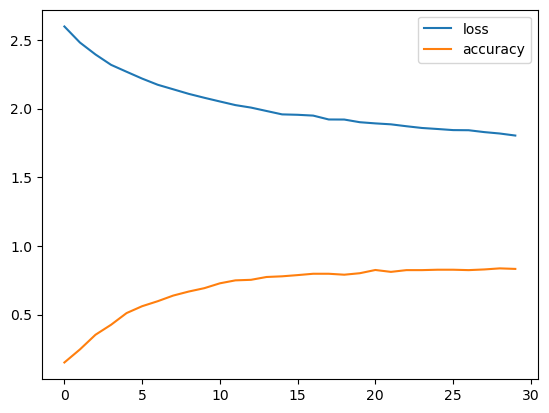

Accuracy: 0.8323529411764706


In [7]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np
import sys

# 设备检测，若未检测到cuda设备则在CPU上运行
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 设置训练集的数据变换，进行数据增强
trainform_train = transforms.Compose([
    transforms.RandomRotation(30), # 随机旋转 -30度到30度之间
    transforms.RandomResizedCrop((224, 224)), # 随机比例裁剪并进行resize
    transforms.RandomHorizontalFlip(p = 0.5), # 随机水平翻转
    transforms.RandomVerticalFlip(p = 0.5), # 随机垂直翻转
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 设置测试集的数据变换，不进行数据增强，仅使用resize和归一化
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # resize
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载训练数据，需要特别注意的是Flowers102数据集，test簇的数据量较多些，所以这里使用"test"作为训练集
train_dataset = datasets.Flowers102(root='../data/flowers102', split="test", download=True, transform=trainform_train)
# 实例化训练数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# 加载测试数据，使用"train"作为测试集
test_dataset = datasets.Flowers102(root='../data/flowers102', split="train", download=True, transform=transform_test)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# 设置epoch数并开始训练
num_epochs = 30  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

# tqdm用于显示进度条并评估任务时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        # 将数据转移到指定计算资源设备上
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 预测、损失函数、反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 记录训练集loss
        total_loss += loss.item()
    
    # 测试模型，不计算梯度
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # 将数据转移到指定计算资源设备上
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 预测
            outputs = model(inputs)
            # 记录测试集预测正确数
            total_correct += (outputs.argmax(1) == labels).sum().item()
        
    # 记录训练集损失和测试集准确率
    loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
    acc_history.append(total_correct / len(test_dataset))# 将准确率加入准确率历史记录列表
    
    # 打印中间值
    if epoch % 10 == 0:
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

# 输出准确率
print("Accuracy:", acc_history[-1])

### VIT

In [8]:
# 从torchvision.models中导入ViT_B_16模型和对应权重
from torchvision.models import vit_b_16, ViT_B_16_Weights

# 使用 vit_b_16 创建一个模型，并指定权重为默认权重
model = vit_b_16(weights = ViT_B_16_Weights.DEFAULT)

In [9]:
# 遍历模型的所有参数，并将其 requires_grad 属性设置为 False
# 冻结模型参数，使它们在训练过程中不会被更新
for parameter in model.parameters():
    parameter.requires_grad = False

In [10]:
# 打印模型结构
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [11]:
# 使用 nn.Linear 创建一个全连接层，输入特征维度为 768，输出特征维度为 102 进行替换
model.heads = nn.Linear(in_features=768, out_features=102, bias=True)

In [12]:
# 遍历模型的所有参数，并打印出它们的名称和 requires_grad 属性
for name, param in model.named_parameters():
    print(name, param.requires_grad)

class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

Epoch: 0 Loss: 2.585463130374999 Acc: 0.17647058823529413
Epoch: 10 Loss: 2.0090513371043364 Acc: 0.7245098039215686
Epoch: 20 Loss: 1.8183318470240557 Acc: 0.8294117647058824
100%|██████████| 30/30 [20:51<00:00, 41.72s/it]


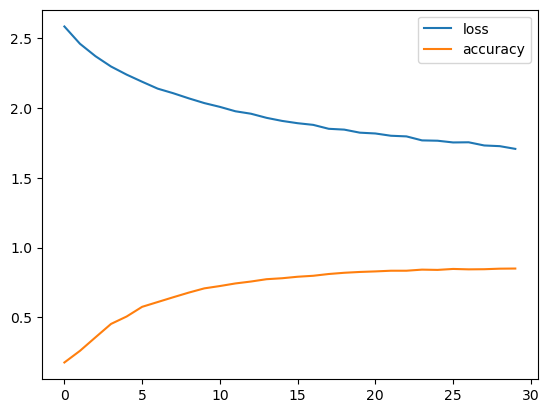

Accuracy: 0.85


In [13]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np
import sys

# 设备检测，若未检测到cuda设备则在CPU上运行
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 设置训练集的数据变换，进行数据增强
trainform_train = transforms.Compose([
    transforms.RandomRotation(30), # 随机旋转 -30度到30度之间
    transforms.RandomResizedCrop((224, 224)), # 随机比例裁剪并进行resize
    transforms.RandomHorizontalFlip(p = 0.5), # 随机水平翻转
    transforms.RandomVerticalFlip(p = 0.5), # 随机垂直翻转
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 设置测试集的数据变换，不进行数据增强，仅使用resize和归一化
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # resize
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载训练数据，需要特别注意的是Flowers102数据集，test簇的数据量较多些，所以这里使用"test"作为训练集
train_dataset = datasets.Flowers102(root='../data/flowers102', split="test", download=True, transform=trainform_train)
# 实例化训练数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# 加载测试数据，使用"train"作为测试集
test_dataset = datasets.Flowers102(root='../data/flowers102', split="train", download=True, transform=transform_test)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# 设置epoch数并开始训练
num_epochs = 30  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

# tqdm用于显示进度条并评估任务时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        # 将数据转移到指定计算资源设备上
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 预测、损失函数、反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 记录训练集loss
        total_loss += loss.item()
    
    # 测试模型，不计算梯度
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # 将数据转移到指定计算资源设备上
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 预测
            outputs = model(inputs)
            # 记录测试集预测正确数
            total_correct += (outputs.argmax(1) == labels).sum().item()
        
    # 记录训练集损失和测试集准确率
    loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
    acc_history.append(total_correct / len(test_dataset))# 将准确率加入准确率历史记录列表
    
    # 打印中间值
    if epoch % 10 == 0:
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

# 输出准确率
print("Accuracy:", acc_history[-1])